In [4]:
import pandas as pd
import random
random.seed(5483)
import numpy as np
np.random.seed(5483)
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('data/training_set/log_mini.csv', dtype={'skip_1':int, 'skip_2':int, 'skip_3':int, 'not_skipped':int, 'hist_user_behavior_is_shuffle':int, 'premium':int})
tf = pd.read_csv('data/track_features/tf_mini.csv')

In [6]:
cols_to_select = [
    'context_switch',
    'context_type',
    'hist_user_behavior_is_shuffle',
    'hist_user_behavior_n_seekback',
    'hist_user_behavior_n_seekfwd',
    'hist_user_behavior_reason_end',
    'hist_user_behavior_reason_start',
    'hour_of_day',
    'long_pause_before_play',
    'no_pause_before_play',
    'not_skipped',
    'premium',
    'session_position',
    'short_pause_before_play',
    'skip_1',
    'skip_2',
    'skip_3',
    'dayofweek']
cols_tf = ['duration', 'release_year', 'us_popularity_estimate',
       'acousticness', 'beat_strength', 'bounciness', 'danceability',
       'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mechanism', 'organism', 'speechiness',
       'tempo', 'time_signature', 'valence', 'acoustic_vector_0',
       'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
       'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6',
       'acoustic_vector_7']
cols_log = ['session_id', 'session_position', 'session_length', 'track_id_clean',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'dayofweek']
data_df = df.loc[lambda x: x.session_length==20]
log_features = data_df.loc[lambda x: x.session_position <= (x.session_length/2)].copy()
log_features.date = pd.to_datetime(log_features.date)
log_features['dayofweek'] = log_features.date.dt.dayofweek
replace_idx = log_features.hist_user_behavior_reason_start.isin(['endplay', 'popup', 'uriopen', 'clickside']).copy()
log_features.loc[replace_idx, 'hist_user_behavior_reason_start'] = 'replaced'
replace_idx = log_features.hist_user_behavior_reason_end.isin(['clickrow', 'appload', 'popup', 'uriopen', 'clickside', 'logout']).copy()
log_features.loc[replace_idx, 'hist_user_behavior_reason_end'] = 'replaced'
tf.rename(columns={'track_id': 'track_id_clean'}, inplace=True)
features = pd.merge(log_features, tf, on=['track_id_clean'], how='inner')
features.sort_values(['session_id', 'session_position'], inplace=True)
features.reset_index(drop=True, inplace=True)
ground_truth = data_df.loc[lambda x: x.session_position > (x.session_length/2)].loc[:, ['session_id', 'session_position', 'session_length', 'track_id_clean', 'skip_2']].copy()
ground_truth.sort_values(['session_id', 'session_position'], inplace=True)
ground_truth.reset_index(drop=True, inplace=True)
pred_y = np.array(ground_truth.groupby('session_id')['skip_2'].apply(lambda x: x.tolist()).tolist())

feats_dummies = pd.get_dummies(features.loc[:, cols_to_select])
feats_track = features.loc[:, cols_tf]
all_seq = np.array(features.reset_index().groupby('session_id')['index'].apply(lambda x: x.tolist()).tolist())
y_seq = np.array(features.reset_index().groupby('session_id')['skip_2'].apply(lambda x: x.tolist()).tolist())[:, -1:]
all_seq = np.concatenate((all_seq, y_seq), axis=1)
cols_order = sorted(feats_dummies.columns.values)
log_mat = feats_dummies.loc[:, cols_order].values
track_mat = feats_track.values
X_train, X_test, y_train, y_test = train_test_split(all_seq, pred_y, test_size=0.2, random_state=5483)



In [7]:
from keras.layers import Embedding, BatchNormalization, Input, Dense, LSTM, concatenate, Bidirectional, RepeatVector, Dropout, Lambda
import keras.backend as K
from keras.optimizers import adam_v2
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [8]:
def model_net(log_mat, track_mat):
  seq_input = Input(shape=(None,), name='log_input')
  log_embed = Embedding(input_dim=log_mat.shape[0], output_dim=log_mat.shape[1], weights=[log_mat], trainable=False, mask_zero=False, name='session_embed')
  track_embed = Embedding(input_dim=track_mat.shape[0], output_dim=track_mat.shape[1], weights=[track_mat],trainable=False,mask_zero=False,name='track_embed')
  log_bn = BatchNormalization(name='bn1')
  log_transformer = Dense(64, activation='relu', name='session_transformer')
  x1 = log_embed(seq_input)
  x1 = log_bn(x1)
  x1 = log_transformer(x1)
  track_bn = BatchNormalization(name='track_bn')
  track_transformer = Dense(64, activation='relu', name='track_transformer')
  x2 = track_embed(seq_input)
  x2 = track_bn(x2)
  x2 = track_transformer(x2)
  x = concatenate([x1, x2], axis=-1)
  x = Bidirectional(LSTM(64, return_sequences=False, return_state=False), name='lstm1')(x)
  x = RepeatVector(1)(x)
  x_en = Dense(256, activation='relu', name='base_transformer')(x)
  _, fwd_sh, fwd_sc, bck_sh, bck_sc = Bidirectional(LSTM(256, return_sequences=False, return_state=True))(x_en)
  fwd_sh = Dropout(0.2)(fwd_sh)
  fwd_sc = Dropout(0.2)(fwd_sc)
  bck_sh = Dropout(0.2)(bck_sh)
  bck_sc = Dropout(0.2)(bck_sc)
  y_p = Input(shape=(1, 1), name='y_seq')
  all_ouputs = []
  decoder_2 = Bidirectional(LSTM(256, return_sequences=True, return_state=True, name='decoder_2'))
  decoder_3 = LSTM(64, return_sequences=True, return_state=True, name='decoder_3')
  decoder_4 = Dropout(0.3)
  decoder_5 = Dense(1, activation='sigmoid', name='decoder_5')
  x = concatenate([x_en, y_p])
  x, fwd_sh, fwd_sc, bck_sh, bck_sc = decoder_2(x, initial_state=[fwd_sh, fwd_sc, bck_sh, bck_sc])
  x, sh, sc = decoder_3(x)
  x = decoder_4(x)
  out = decoder_5(x)
  all_ouputs.append(out)

  for i in range(1, 10):
    x = concatenate([x_en, out])
    x, fwd_sh, fwd_sc, bck_sh, bck_sc = decoder_2(x, initial_state=[fwd_sh, fwd_sc, bck_sh, bck_sc])
    x, sh, sc = decoder_3(x)
    x = decoder_4(x)
    out = decoder_5(x)
    all_ouputs.append(out)
  out_combined = Lambda(lambda x: K.concatenate(x, axis=1))(all_ouputs)
  model = Model(inputs=[seq_input, y_p], outputs=[out_combined])
  model.compile(optimizer=adam_v2.Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [9]:
model = model_net(log_mat, track_mat)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 log_input (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 session_embed (Embedding)      (None, None, 36)     1823760     ['log_input[0][0]']              
                                                                                                  
 track_embed (Embedding)        (None, None, 28)     1418480     ['log_input[0][0]']              
                                                                                                  
 bn1 (BatchNormalization)       (None, None, 36)     144         ['session_embed[0][0]']          
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                 (None, 64)]                      'bidirectional_1[2][0]',        
                                                                  'bidirectional_1[3][0]',        
                                                                  'bidirectional_1[4][0]',        
                                                                  'bidirectional_1[5][0]',        
                                                                  'bidirectional_1[6][0]',        
                                                                  'bidirectional_1[7][0]',        
                                                                  'bidirectional_1[8][0]',        
                                                                  'bidirectional_1[9][0]']        
                                                                                                  
 dropout_4 (Dropout)            (None, 1, 64)        0           ['decoder_3[0][0]',              
          

In [10]:
callbacks = [
    EarlyStopping(monitor='val_loss',
                     patience=15,
                     verbose=1,
                     min_delta=1e-4,
                     mode='min'),
    ReduceLROnPlateau(monitor='val_loss',
                         factor=0.1,
                         patience=4,
                         verbose=1,
                         epsilon=1e-4,
                         mode='min'),
    ModelCheckpoint(monitor='val_loss',
                       filepath='model_weights_best.h5',
                       save_best_only=True,
                       save_weights_only=True)
]

In [11]:
hist = model.fit(
    x=[X_train[:, :-1], X_train[:, -1:]], 
    y=y_train, 
    batch_size=128, 
    epochs=100, 
    verbose=1, 
    callbacks=callbacks, 
    validation_split=0.1, 
    shuffle=True)

Epoch 1/100
29/29 [==============================] - 94s 1s/step - loss: 0.6788 - accuracy: 0.5621 - val_loss: 0.6994 - val_accuracy: 0.5559 - lr: 0.0100
Epoch 2/100
29/29 [==============================] - 4s 135ms/step - loss: 0.6292 - accuracy: 0.6707 - val_loss: 0.7028 - val_accuracy: 0.5559 - lr: 0.0100
Epoch 3/100
29/29 [==============================] - 4s 127ms/step - loss: 0.6168 - accuracy: 0.6775 - val_loss: 0.6749 - val_accuracy: 0.5823 - lr: 0.0100
Epoch 4/100
29/29 [==============================] - 3s 116ms/step - loss: 0.6123 - accuracy: 0.6817 - val_loss: 0.7124 - val_accuracy: 0.5567 - lr: 0.0100
Epoch 5/100
29/29 [==============================] - 4s 122ms/step - loss: 0.6063 - accuracy: 0.6881 - val_loss: 0.6641 - val_accuracy: 0.5867 - lr: 0.0100
Epoch 6/100
29/29 [==============================] - 3s 117ms/step - loss: 0.5972 - accuracy: 0.6950 - val_loss: 0.6657 - val_accuracy: 0.5956 - lr: 0.0100
Epoch 7/100
29/29 [==============================] - 4s 131ms/step

In [18]:
def plot_func(y_list, x_list, label_list, title):
  plt.figure()
  for i in range(len(x_list)):
    x = x_list[i]
    y = y_list[i]
    label = label_list[i]
    plt.plot(x, y, label=label)
  plt.title(title)
  plt.legend()
  plt.savefig(title+'.png')
  plt.show()
  return

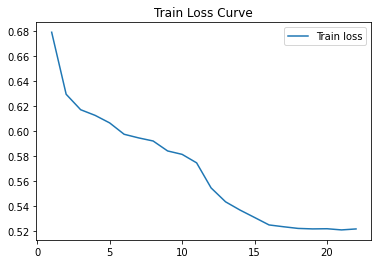

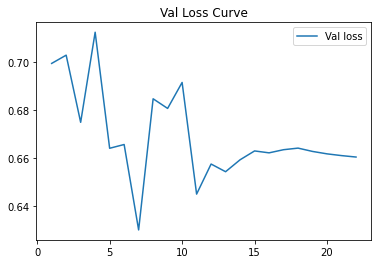

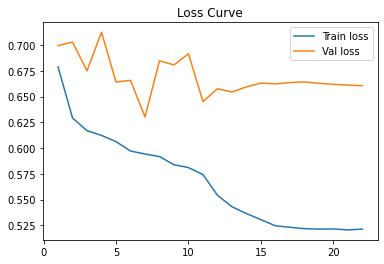

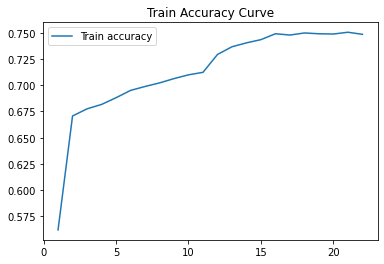

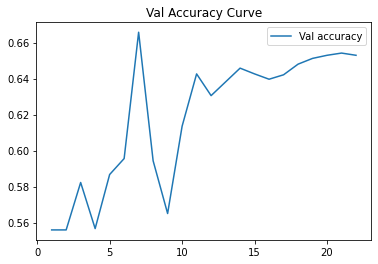

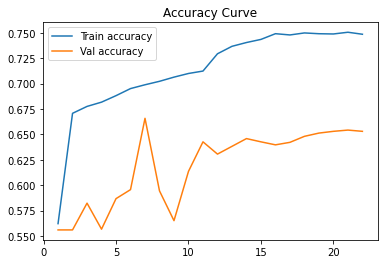

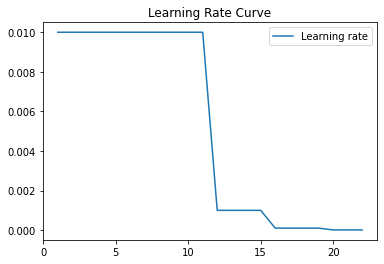

In [19]:
import matplotlib.pyplot as plt
info_hist = hist.history
y = np.arange(1, len(info_hist['loss'])+1)
plot_func([info_hist['loss']], [y], ['Train loss'], 'Train Loss Curve')
plot_func([info_hist['val_loss']], [y], ['Val loss'], 'Val Loss Curve')
plot_func([info_hist['loss'], info_hist['val_loss']], [y, y], ['Train loss', 'Val loss'], 'Loss Curve')
plot_func([info_hist['accuracy']], [y], ['Train accuracy'], 'Train Accuracy Curve')
plot_func([info_hist['val_accuracy']], [y], ['Val accuracy'], 'Val Accuracy Curve')
plot_func([info_hist['accuracy'], info_hist['val_accuracy']], [y, y], ['Train accuracy', 'Val accuracy'], 'Accuracy Curve')
plot_func([info_hist['lr']], [y], ['Learning rate'], 'Learning Rate Curve')

In [12]:
model.load_weights('model_weights_best.h5')
loss, acc = model.evaluate(
    x=[X_test[:, :-1], X_test[:, -1:]], 
    y=y_test
)
print('Test Loss:{}.\nTest Accuracy:{}.'.format(loss, acc))

32/32 [==============================] - 1s 33ms/step - loss: 0.6234 - accuracy: 0.6689
Test Loss:0.6233710050582886.
Test Accuracy:0.6689349412918091.
